In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pyreadr
import os

import timeit

from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from xgboost import plot_tree

In [2]:
masonhtdf = pd.read_csv('../../data/masonht.csv').drop('Unnamed: 0', axis=1)
masonhtdf = masonhtdf[[ 'x', 'y', 'Habitat', 'DEM', 'sDEM', 'hDEM', 'DSM', 'CHM', 'Aspect', 'Slope',
       'Curvature', 'PlanCurv', 'ProfileCurv', 'NDVI', 'NDRE', 'NDWI', 'Wetland']]

In [3]:
df = pd.DataFrame()

for filename in os.scandir('../../Data'):
    if filename.is_file():
        p = filename.path
        if(p != '../../Data\MasonHT.csv' and p!='../../Data\MasonLT.csv'):
            df_temp = pd.read_csv(p)
            df.reset_index(drop=True, inplace=True)
            df_temp.reset_index(drop=True, inplace=True)
            df = pd.concat([df, df_temp])

df=df.drop(['Unnamed: 0'], axis=1)

In [4]:
X_train = df.drop(['x', 'y', 'Habitat', 'Wetland'], axis=1)
y_train = df.Wetland

X_test = masonhtdf.drop(['x', 'y', 'Habitat', 'Wetland'], axis=1)
y_test = masonhtdf.Wetland

[[48  8]
 [15 82]]
              precision    recall  f1-score   support

           0     0.7619    0.8571    0.8067        56
           1     0.9111    0.8454    0.8770        97

    accuracy                         0.8497       153
   macro avg     0.8365    0.8513    0.8419       153
weighted avg     0.8565    0.8497    0.8513       153

0.3552373999999996


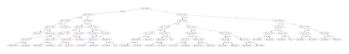

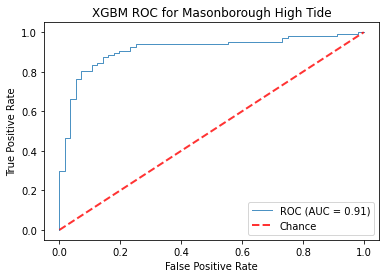

In [5]:
start_time = timeit.default_timer()

model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=69)

model.fit(X_train, y_train)
pred_values = model.predict(X_test)

elapsed = timeit.default_timer() - start_time

tree = plot_tree(model, orientation='vertical')

feature_importance = model.feature_importances_

fig, ax = plt.subplots()
viz = plot_roc_curve(model, X_test, y_test, name='ROC', alpha=0.8, lw=1, ax = ax)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="XGBM ROC for Masonborough High Tide")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
ax.legend(loc="lower right")

Truth = y_test.values.reshape(y_test.shape)
Output = pred_values

feature_importances = pd.DataFrame()
feature_importance = model.feature_importances_
rel_imp = pd.DataFrame(feature_importance, index=X_train.columns, columns=[0])
feature_importances = pd.concat([feature_importances, rel_imp], axis=1)[0]

print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output, digits=4))
print(elapsed)

Text(0.5, 1.0, 'Variable Importance for Masonboro High Tide')

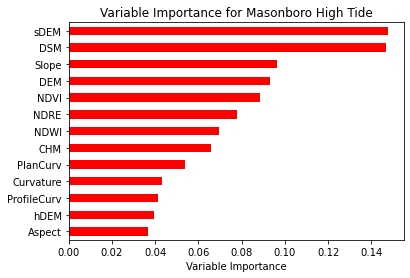

In [7]:
fig = feature_importances.sort_values()[-24:].T.plot(kind = 'barh', 
               color = 'r')
fig.set_xlabel("Variable Importance")
fig.set_title("Variable Importance for Masonboro High Tide")

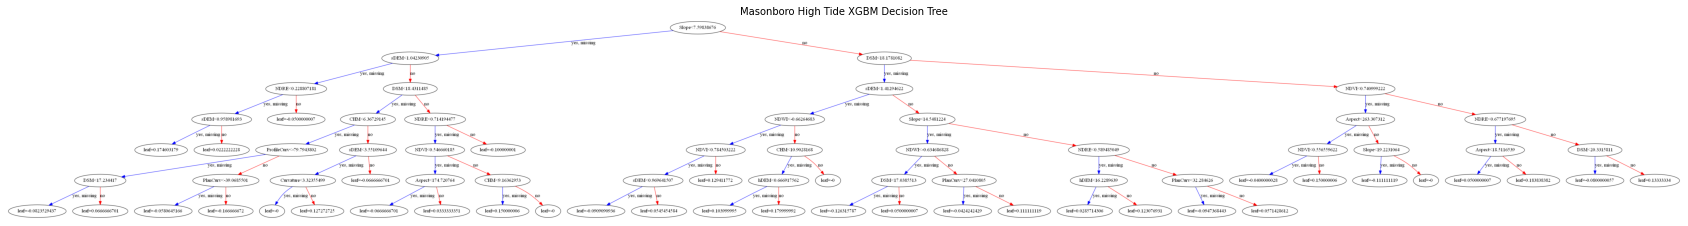

In [14]:
_, ax = plt.subplots(figsize=(30,10)) # Resize figure
plot_tree(model, filled=True, ax=ax, orientation='vertical')
plt.title("Masonboro High Tide XGBM Decision Tree", fontsize=10)
plt.savefig('MasonHTDT.png', dpi=1000)

Text(0.5, 1.0, 'Masonboro High Tide SDEM')

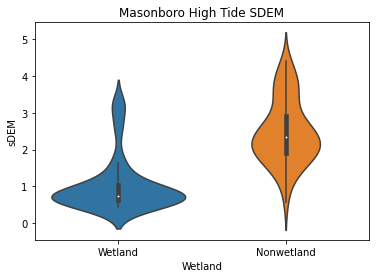

In [51]:
plotdf = masonhtdf.copy()
plotdf.loc[plotdf["Wetland"]==0, "Wetland"] = "Nonwetland"
plotdf.loc[plotdf["Wetland"]==1, "Wetland"] = "Wetland"
p = sns.violinplot(data=plotdf, x="Wetland", y="sDEM")
p.set_title("Masonboro High Tide SDEM")

In [15]:
result = pyreadr.read_r('../../../MasonHT/MasonHT_all.rds')
df_all = result[None]

In [17]:
X_all = df_all.drop(['x', 'y', 'Habitat'], axis=1)
coords_all = df_all[['x', 'y']]
Coords = coords_all
Output = []

In [18]:
pred_values = model.predict(X_all)
Output.extend(pred_values)

In [20]:
test_df = pd.concat([Coords, pd.DataFrame(Output, columns=["Output"])], axis=1)
test_df['Output'].value_counts()

1    5341151
0    2132372
Name: Output, dtype: int64

In [22]:
test_df.to_csv("../Comparison Data/MasonHTAll.csv", index=False)